<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting**

In [160]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import collections
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

2.2.0-rc4


https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# **Data Exploration**

In [161]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


In [162]:
series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "price"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
series.head()

,price
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


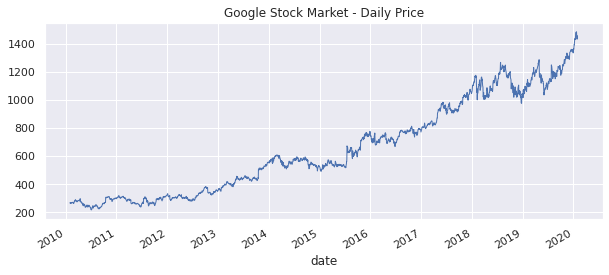

In [163]:
sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
series.price.plot(title='Google Stock Market - Daily Price')

In [0]:
differenced = series.copy()
# differenced = differenced.drop(columns=['price])
differenced['price'] = ((series.price) - ((series.price).shift(1)))
# differenced['past'] = ((series.past) - ((series.past).shift(1)))
differenced = differenced.dropna()
differenced.head()

,price
date,
2010-02-02,-0.946442
2010-02-03,4.831879
2010-02-04,-6.993775
2010-02-05,2.246582
2010-02-08,1.085938


**Load Data & Extract Numpy Array for Model Training**

In [164]:
# dataframe = differenced.copy()
dataframe = series.copy()
dataframe = dataframe.rename(columns={"price": "values"})
dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')
dataset_orig

array([[ 265.51477],
       [ 264.56833],
       [ 269.4002 ],
       ...,
       [1433.9    ],
       [1452.56   ],
       [1458.63   ]], dtype=float32)

# **Univariate Time Series Forecasting**

## **Data Preparation**

**Set Seed & Preprocessing Hyperparameter**

In [0]:
seed = 7
tf.random.set_seed(seed)

In [0]:
window = 2
features = 1

**Data Normalization (LSTMs are sensitive to scale of input data)**

In [0]:
dataset = dataset_orig.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

**Train & Test Data Split**

In [0]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

**Convert an array of values into a dataset matrix**

Now we can define a function to create a new dataset, as described above. The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the window, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1. This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).


In [0]:
def create_dataset(dataset, window=window):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):
		a = dataset[i:(i+window), 0]
		dataX.append(a)
		dataY.append(dataset[i + window, 0])
	return np.array(dataX), np.array(dataY)

**Window Method**

In [0]:
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

* We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step. This is called a window, and the size of the window is a parameter that can be tuned for each problem.
* For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.
* When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.
* The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

## **First Model**

**Reshape Data Format for LSTM**

* Data is in form: [samples, features]. LSTM expects **shape = [samples, time steps, features]** 
* Reshape into X=t and Y=t+1 to prepare the train and test datasets for modeling.
* Use past observations as time steps of the one input feature, & feature dimension = 1
* Remember tf.shape returns the shape of the ndarray as a tuple. For a 2D array, the shape would be (n,m) where n is the number of rows (here: time steps / windows) and m is the number of columns in the array (here: time series)

In [0]:
trainX = tf.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = tf.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [187]:
trainX

<tf.Tensor: shape=(1683, 1, 1), dtype=float32, numpy=
array([[[0.03804384]],

       [[0.03729828]],

       [[0.04110461]],

       ...,

       [[0.4374716 ]],

       [[0.4405202 ]],

       [[0.44055167]]], dtype=float32)>

**Set Hyperparameter**

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = 'mean_squared_error'
activation = 'tanh'
recurrent_activation='sigmoid'
epochs = 20
repeat = 2
batch_size = 1
verbose = 1
units = 4
dropout = 0.02
recurrent_dropout = 0.02

**Create Model** 

Stacked LSTM with Memory Between Batches

In [0]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1), 
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True, 
               return_sequences=True))
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1),
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True))
model.add(layers.Dense(1))

**Display Model Topology**

In [273]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (1, 2, 4)                 96        
_________________________________________________________________
lstm_25 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dense_12 (Dense)             (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


**Compile Model**

In [0]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

**Train Model**

In [0]:
for i in range(repeat):
	model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)
	model.reset_states()

## **Second Model**

**Reshape Data Format for LSTM**

* Data is in form: [samples, features]. LSTM expects shape = [samples, time steps, features]
* Reshape into X=t and Y=t+1 to prepare the train and test datasets for modeling.
* Notice the different shape in comparison to the previous example
* Here we use past observations as input features (=3) and only one time step

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [286]:
trainX

array([[[0.03804384, 0.03729828]],

       [[0.03729828, 0.04110461]],

       [[0.04110461, 0.03559524]],

       ...,

       [[0.44119766, 0.4374716 ]],

       [[0.4374716 , 0.4405202 ]],

       [[0.4405202 , 0.44055167]]], dtype=float32)

**Create an run model**

* Notice that here we have a much simpler LSTM for regression
* There is no memory between batches and no stateful

In [287]:
# Model create and train
model = Sequential()
model.add(LSTM(4, input_shape=(1, window)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
 - 2s - loss: 0.0020
Epoch 2/5
 - 2s - loss: 4.4511e-05
Epoch 3/5
 - 2s - loss: 4.6520e-05
Epoch 4/5
 - 2s - loss: 4.7572e-05
Epoch 5/5
 - 2s - loss: 4.9131e-05


## **Predictions**

**Make Predictions**

In [0]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

**Invert predictions**

In [0]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

**Calculate RMSE**

In [290]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.41 RMSE
Test Score: 75.17 RMSE


**Plot results**

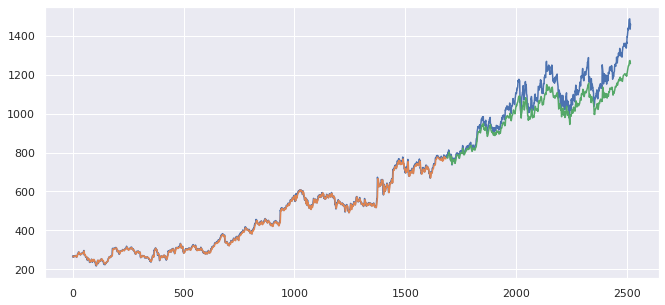

In [291]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
sns.set(rc={'figure.figsize':(11, 5)})
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## **Residual Analysis**

**Get residuals**

In [246]:
residuals = (testY[0] - testPredict[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,490.891716
1,414.984560
2,320.106395
3,239.539874
4,173.101376


In [247]:
res.describe()

,residuals
count,829.000000
mean,171.876566
std,104.278422
min,-36.740211
25%,91.977105
50%,173.101376
75%,240.324171
max,490.891716


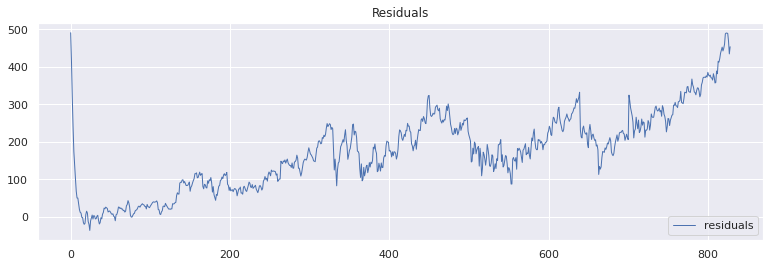

In [248]:
# Visualize Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
res.plot(title='Residuals')

Residuals have:
* not zero mean
* clearly a trend (upwards)